## 1. Introduction and Description

In this notebook we will perform an Exploratory Data Analysis, train various model architectures and perform some hyperparameter tuning for the Kaggle Natural Language Processing with Disaster Tweets competition (https://www.kaggle.com/competitions/nlp-getting-started). We will try various model architectures with LSTM's and GRU models and look at the performance between the various models.

The Kaggle competition is summarized as follows:

*In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t.*

The challenge is to build a binary classifier model that can make the correct predictions for the tweet textimages. In total we have about 10000 tweets that were hand classified on whether they are about a real disaster or not. All data is provided with CSV files. There are about 7600 training samples and 3200 testing samples. We need to create a submission file based on the 3200 test samples.

The evaluation of the Kaggle competition submission is done using the F1 score between the predicted and expected answers.

## 2. Exploratory Data Analysis

In this section we will perform some basic Exploratory Data Analysis about the data.

As a first step we will import the required Python modules, set some some basic constants and directory variables and import the CSV file that contains the training dataset labels.

In [1]:
# Import Modules
import numpy as np
import pandas as pd
from collections import Counter
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# NLTK for English Stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

# Token Vectorizer
from sklearn.feature_extraction.text import CountVectorizer

# Sklearn Models
from sklearn.ensemble import GradientBoostingClassifier

# Tensorflow
import tensorflow as tf
from tensorflow.keras.layers import Bidirectional , Dense, Dropout, Embedding, GRU, LSTM

# Constants
BASE_DIR = 'C:/DTSA5311/nlp-getting-started/'

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\robin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import Train Data
train_df = pd.read_csv(f'{BASE_DIR}/train.csv')
print(train_df.shape)
train_df.head()

(7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


So we have 7613 rows for training data. Each row contains 'text' and a 'target'. The 'text' will be tokenized to be able to use it as input features.
The 'target' provides the label that we want to be able to predict.

Let's continue with importing the test data.

In [3]:
# Import Test Data
test_df = pd.read_csv(f'{BASE_DIR}/test.csv')
print(test_df.shape)
test_df.head()

(3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


The imported test data has the same structure as the training dataset except for the 'target' column.

As a final we have the sample submission file to be imported.

In [4]:
# Import Submission File
submission_df = pd.read_csv(f'{BASE_DIR}/sample_submission.csv')
print(submission_df.shape)
submission_df.head()

(3263, 2)


,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


Lets take a closer look at the 'target' label distribution.

In [5]:
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

We have 4342 of 0 labels and 3271 of 1 labels. The dataset is slightly unbalanced considering the label distribution. Allthough this likely won't affect the training of the models much lets make the dataset balanced. I will do this by downsampling the 0 labels to the same amount as the 1 labels.

New balanced data set shape: (6542, 5)


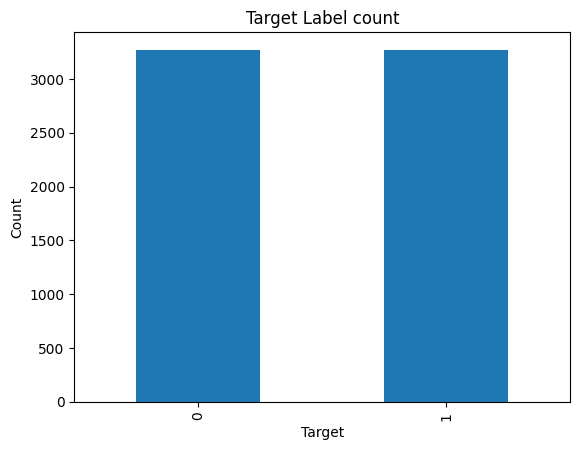

In [6]:
# Downsample data to balance labels
label1_df = train_df[train_df.target == 1]
label0_df = train_df[train_df.target == 0].sample(n = 3271, random_state = 42)
train_df = pd.concat([label0_df, label1_df])
print(f'New balanced data set shape: {train_df.shape}')

# Plot Label count
train_df.target.value_counts().plot(kind = 'bar')
plt.title('Target Label count')
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()

We can see that we now have a balanced data set with equal amount of 0 and 1 labels. 

With around 6500 training samples this is not a very large dataset to train an NLP model. It should be enough though to train some simple NLP models

Next we will perform some data cleaning:
1. Lowercase all text.
2. Remove all English Stopwords. These usually have a high occurence but add very little value.

No further data cleaning will be done.

And as a final steps we will determine the count of Words per Text. This will give us some insights into the overall Text distribution.

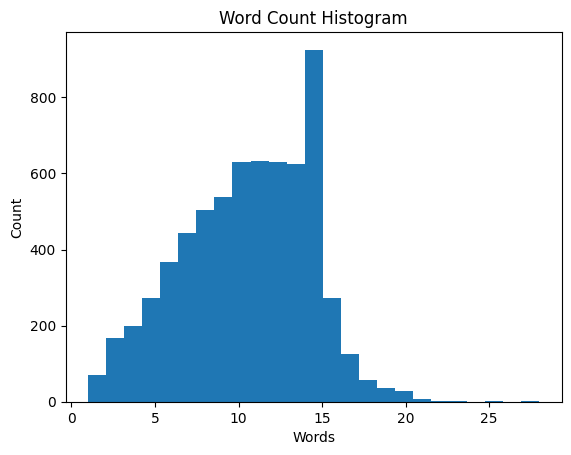

In [7]:
# Lowercase all text
train_df['text'] = train_df['text'].apply(str.lower)

# Remove all Stopwords.
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([stopword for stopword in x.split() if stopword not in (english_stopwords)]))

# Count number of words
train_df['TextWordCount'] = train_df['text'].str.split(' ').str.len()

# Plot Word Count Histogram
ax = train_df.TextWordCount.plot.hist(by = None, bins = 25)
plt.title("Word Count Histogram")
plt.ylabel('Count')
plt.xlabel('Words')
plt.show()

Looking at the histogram all samples have a cleaned text length of between 1 and 20 words with samples having up to 30 words. Based on this the maximum length of words that will be tokenized for our models is 32.

Next lets take a look at the top 10 of most occuring words for each of the target labels.

In [8]:
# All text for target 0  
text_set_target0 = train_df[train_df.target == 0].text.to_string()
target0_counter = Counter(text_set_target0.split())
target0_top10k = target0_counter.most_common(10)
  
# Show Top 10
print('======== Top 10 Word Count for Target: 0')
for i, count_tuple in enumerate(target0_top10k):
    print(f'\t{i+1}: \t {count_tuple[0]} \t\t Count: {count_tuple[1]}')

======== Top 10 Word Count for Target: 0
	1: 	 ... 		 Count: 350
	2: 	 i'm 		 Count: 123
	3: 	 like 		 Count: 118
	4: 	 - 		 Count: 109
	5: 	 new 		 Count: 106
	6: 	 get 		 Count: 89
	7: 	 ?? 		 Count: 71
	8: 	 &amp; 		 Count: 63
	9: 	 one 		 Count: 61
	10: 	 got 		 Count: 49


If we look at the top 10 of most occuring words for the 'target' label 0 it is noticable that the words are not very 'expresive'. This makes sense since label 0 means no disaster.

Lets look at the top 10 of most occuring words for the 'target' label 1 ... this should be quite a different list of words as label 1 means that there are in fact disasters.

In [9]:
# All text for target 1 
text_set_target0 = train_df[train_df.target == 1].text.to_string()
target0_counter = Counter(text_set_target0.split())
target0_top10k = target0_counter.most_common(10)
  
# Show Top 10
print('======== Top 10 Word Count for Target: 1')
for i, count_tuple in enumerate(target0_top10k):
    print(f'\t{i+1}: \t {count_tuple[0]} \t\t Count: {count_tuple[1]}')

======== Top 10 Word Count for Target: 1
	1: 	 ... 		 Count: 413
	2: 	 - 		 Count: 121
	3: 	 fire 		 Count: 93
	4: 	 suicide 		 Count: 73
	5: 	 california 		 Count: 66
	6: 	 h... 		 Count: 63
	7: 	 like 		 Count: 58
	8: 	 police 		 Count: 55
	9: 	 families 		 Count: 55
	10: 	 killed 		 Count: 53


It is clear that there are a lot of alerting words in the top 10 like: fire, suicide, killed etc.

## 3. Model Architectures and Training

In this section we will setup a few different NLP models with LSTM / GRU layers. These models will be extended with Bidirectional layers and we will explore the use of 2 LSTM / GRU layers.

To be able to compare the performance of the LSTM / GRU models we will also train a classic GradientBoostingClassifier. 

For all models we will use the same training and validation sets to be able to perform a fair comparison.

As a final step we will also use one of the trained models to perform the predictions on the test data and submit a submission file to the Kaggle competition.

The achieved performances of all models will be discussed in the Result and Analysis section.

### 3.1 Setup and Preparation



First we will define some functions for saving the models and tokenizations.

In [10]:
# Model Checkpointing
def model_checkpoint(model_name):
    return tf.keras.callbacks.ModelCheckpoint(model_name,
                                              monitor = 'val_loss',
                                              verbose = 0,
                                              save_best_only = True,
                                              save_weights_only = False,
                                              mode = 'min',
                                              save_freq = 'epoch')

def count_vectorize_text(df, max_features):
    # Specify Count Vectorizer with specific number_of_features
    count_vectorizer = CountVectorizer(input = 'content', 
                                       encoding = 'utf-8', 
                                       analyzer = 'word', 
                                       max_features = max_features)

    # Fit the Count Vectorizer on all Text
    count_vectorizer.fit(df.text) 

    # Vectorize all Text
    X = count_vectorizer.transform(df.text)
    y = df.target.values

    return X, y

def keras_vectorize_text(df, max_words, max_length):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words = max_words,
                                                      filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                                                      lower = True,
                                                      split = ' ',
                                                      char_level = False,
                                                      oov_token = None,
                                                      analyzer = None)

    # Tokenize fit on texts
    tokenizer.fit_on_texts(df.text.values)

    # Prepare text
    X = tokenizer.texts_to_sequences(df.text.values)

    # Truncate / Pad text for fixed length for LSTM / GRU
    X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen = max_length)

    # Set Target
    y = df.target.values

    return tokenizer, X, y    

### 3.2 Gradient Boosting Classifier



In [11]:
# Prepare input features X and labels y.
X, y = count_vectorize_text(train_df, 2500)
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, stratify = y, shuffle = True, random_state = 42)

# Fit and Predict GradientBoostingClassifier Model
clf = GradientBoostingClassifier(n_estimators = 1000, learning_rate = 0.02, max_depth = 8, random_state = 42)
clf.fit(x_train, y_train)
accuracy = clf.score(x_valid, y_valid)

# Summary
print(f'Gradient Boosting Classifier -   Accuracy: {accuracy:.4f}')

Gradient Boosting Classifier -   Accuracy: 0.7464


### 3.3 Basic LSTM Model



Before setting up the first LSTM model we need to tokenize the text first and split it into training and validation sets.

For tokenizing the text for the LSTM and GRU models we won't use the Count Vectorizer but use the Keras specific tokenization tools.

We will use the top 2500 most occuring words to build up our tokenization. All tokenization vectors will be padded/truncated to a maximum of 32 words. All Models contain an Embedding layer. The output of each Embedding layer is also a vector of 32 float numbers.

The train_test_split will use 20% of all data for validation.

In [12]:
# Prepare input features X and labels y.
max_words = 2500
max_length = 32
embedding_vecor_length = 32
tokenizer, X, y = keras_vectorize_text(train_df, max_words = max_words, max_length = max_length)

# Create Training and Validation sets
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, stratify = y, shuffle = True, random_state = 42)

Next we will setup the first basic LSTM model, train and validate it and plot the results.

All models will be trained for 25 epochs, with a batch size of 64 and use an Adam optimizer with a learning rate of 0.0001.

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 32)            80000     
                                                                 
 lstm (LSTM)                 (None, 64)                24832     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 104,897
Trainable params: 104,897
Non-trainable params: 0
_________________________________________________________________
None
Best Validation Loss: 0.4785 at Epoch: 8
Best Validation Accuracy: 0.7731 at Epoch: 12


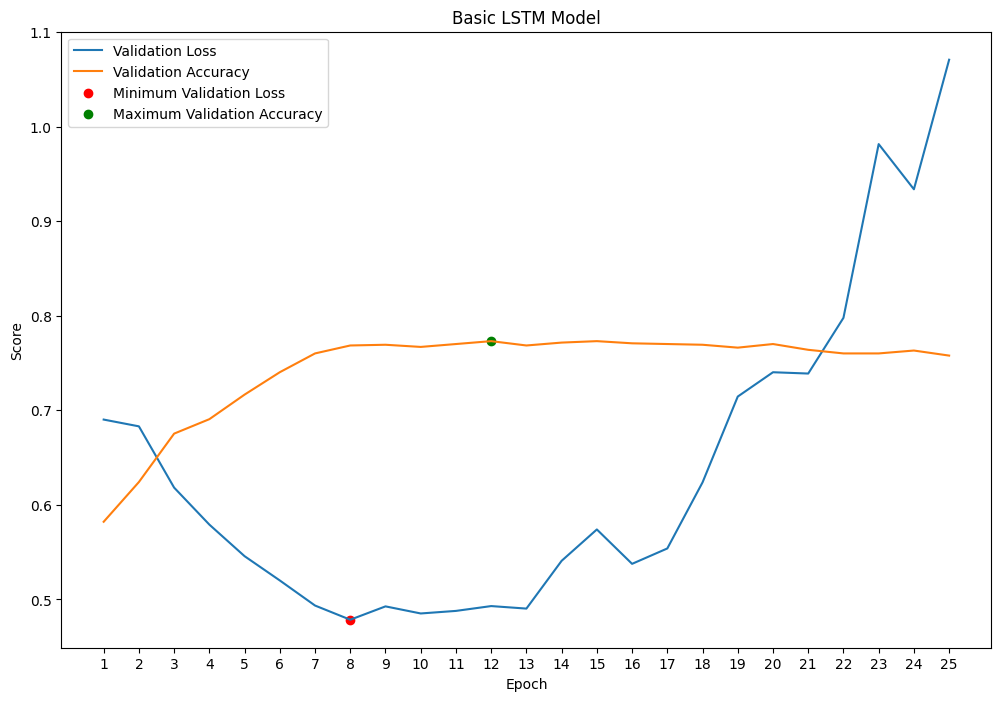

In [13]:
# Create model
model = tf.keras.models.Sequential()
model.add(Embedding(max_words, embedding_vecor_length, input_length = max_length))
model.add(LSTM(64, activation = 'relu', dropout = 0.1, recurrent_dropout = 0.1))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

# Show Model Summary
print(model.summary())

# Fit Model and Validate
epochs = 25
history = model.fit(x_train, 
                    y_train, 
                    validation_data = (x_valid, y_valid), 
                    epochs = epochs, 
                    batch_size = 64,
                    verbose = 0)

# Print Summary
min_valloss_x = np.argmin(history.history['val_loss']) + 1
min_valloss_y = np.min(history.history['val_loss'])
print(f'Best Validation Loss: {min_valloss_y:.4f} at Epoch: {min_valloss_x}')
max_valacc_x = np.argmax(history.history['val_accuracy']) + 1
max_valacc_y = np.max(history.history['val_accuracy'])
print(f'Best Validation Accuracy: {max_valacc_y:.4f} at Epoch: {max_valacc_x}')

# Plot Results
epochs_list = [*range(1, epochs + 1, 1)]
plt.figure(figsize = (12, 8))
plt.title('Basic LSTM Model')
plt.plot(epochs_list, history.history['val_loss'], label = "Validation Loss")
plt.plot(epochs_list, history.history['val_accuracy'], label = "Validation Accuracy")
plt.scatter(min_valloss_x, min_valloss_y, c = 'r', label = 'Minimum Validation Loss')
plt.scatter(max_valacc_x, max_valacc_y, c = 'g', label = 'Maximum Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_list)
plt.ylabel('Score')
plt.legend()
plt.show()

### 3.4 Basic GRU Model



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 32, 32)            80000     
                                                                 
 gru (GRU)                   (None, 64)                18816     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 98,881
Trainable params: 98,881
Non-trainable params: 0
_________________________________________________________________
None
Best Validation Loss: 0.4695 at Epoch: 9
Best Validation Accuracy: 0.7792 at Epoch: 14


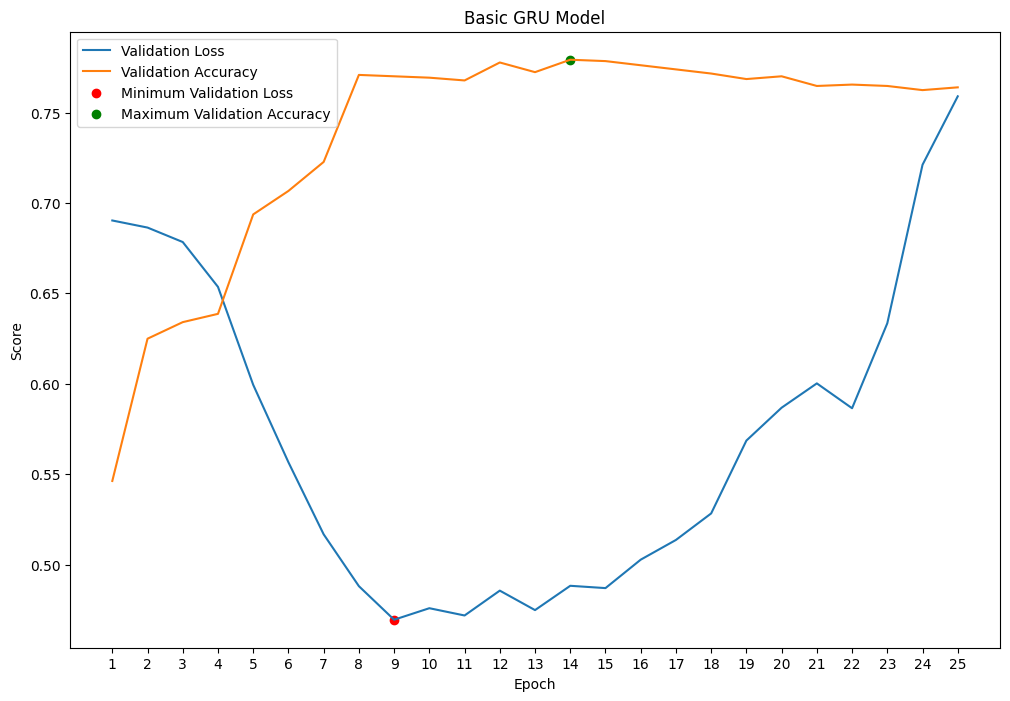

In [14]:
# Create model
model = tf.keras.models.Sequential()
model.add(Embedding(max_words, embedding_vecor_length, input_length = max_length))
model.add(GRU(64, activation = 'relu', dropout = 0.1, recurrent_dropout = 0.1))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

# Show Model Summary
print(model.summary())

# Fit Model and Validate
epochs = 25
history = model.fit(x_train, 
                    y_train, 
                    validation_data = (x_valid, y_valid), 
                    epochs = epochs, 
                    batch_size = 64,
                    verbose = 0)

# Print Summary
min_valloss_x = np.argmin(history.history['val_loss']) + 1
min_valloss_y = np.min(history.history['val_loss'])
print(f'Best Validation Loss: {min_valloss_y:.4f} at Epoch: {min_valloss_x}')
max_valacc_x = np.argmax(history.history['val_accuracy']) + 1
max_valacc_y = np.max(history.history['val_accuracy'])
print(f'Best Validation Accuracy: {max_valacc_y:.4f} at Epoch: {max_valacc_x}')

# Plot Results
epochs_list = [*range(1, epochs + 1, 1)]
plt.figure(figsize = (12, 8))
plt.title('Basic GRU Model')
plt.plot(epochs_list, history.history['val_loss'], label = "Validation Loss")
plt.plot(epochs_list, history.history['val_accuracy'], label = "Validation Accuracy")
plt.scatter(min_valloss_x, min_valloss_y, c = 'r', label = 'Minimum Validation Loss')
plt.scatter(max_valacc_x, max_valacc_y, c = 'g', label = 'Maximum Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_list)
plt.ylabel('Score')
plt.legend()
plt.show()

### 3.5 Bidirectional LSTM Model



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 32, 32)            80000     
                                                                 
 bidirectional (Bidirectiona  (None, 128)              49664     
 l)                                                              
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 129,793
Trainable params: 129,793
Non-trainable params: 0
_________________________________________________________________
None
Best Validation Loss: 0.4724 at Epoch: 11
Best Validation Accuracy: 0.7861 at Epoch: 11


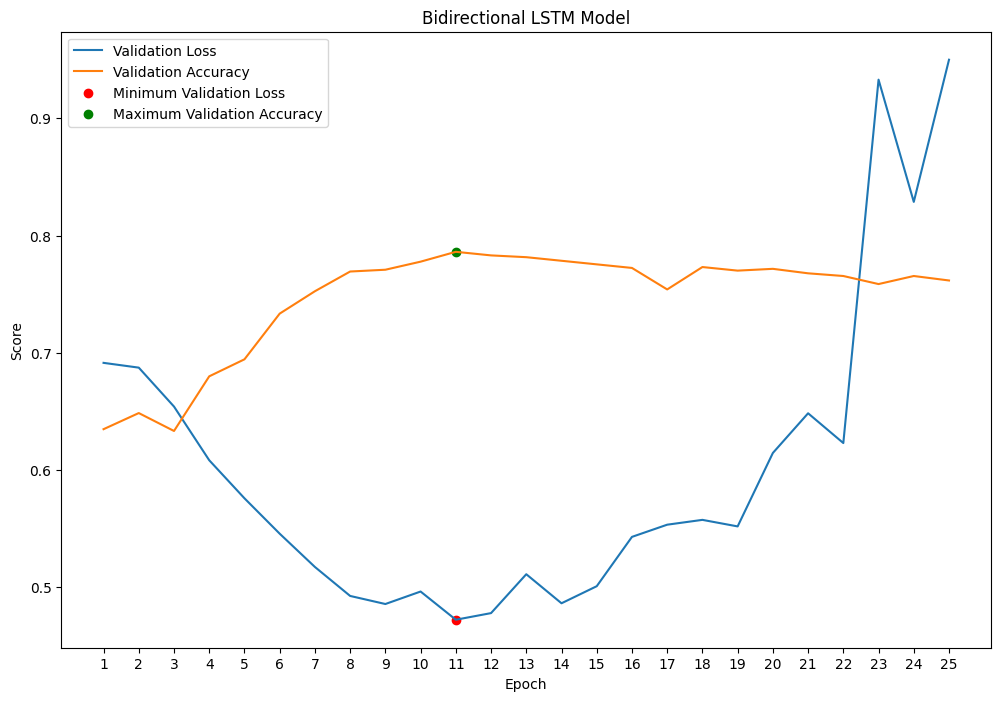

In [15]:
# Create model
model = tf.keras.models.Sequential()
model.add(Embedding(max_words, embedding_vecor_length, input_length = max_length))
model.add(Bidirectional(LSTM(64, activation = 'relu', dropout = 0.1, recurrent_dropout = 0.1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

# Show Model Summary
print(model.summary())

# Fit Model and Validate
epochs = 25
history = model.fit(x_train, 
                    y_train, 
                    validation_data = (x_valid, y_valid), 
                    epochs = epochs, 
                    batch_size = 64,
                    verbose = 0)

# Print Summary
min_valloss_x = np.argmin(history.history['val_loss']) + 1
min_valloss_y = np.min(history.history['val_loss'])
print(f'Best Validation Loss: {min_valloss_y:.4f} at Epoch: {min_valloss_x}')
max_valacc_x = np.argmax(history.history['val_accuracy']) + 1
max_valacc_y = np.max(history.history['val_accuracy'])
print(f'Best Validation Accuracy: {max_valacc_y:.4f} at Epoch: {max_valacc_x}')

# Plot Results
epochs_list = [*range(1, epochs + 1, 1)]
plt.figure(figsize = (12, 8))
plt.title('Bidirectional LSTM Model')
plt.plot(epochs_list, history.history['val_loss'], label = "Validation Loss")
plt.plot(epochs_list, history.history['val_accuracy'], label = "Validation Accuracy")
plt.scatter(min_valloss_x, min_valloss_y, c = 'r', label = 'Minimum Validation Loss')
plt.scatter(max_valacc_x, max_valacc_y, c = 'g', label = 'Maximum Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_list)
plt.ylabel('Score')
plt.legend()
plt.show()

### 3.5 Bidirectional GRU Model



Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 32, 32)            80000     
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              37632     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 117,761
Trainable params: 117,761
Non-trainable params: 0
_________________________________________________________________
None
Best Validation Loss: 0.4719 at Epoch: 12
Best Validation Accuracy: 0.7800 at Epoch: 12


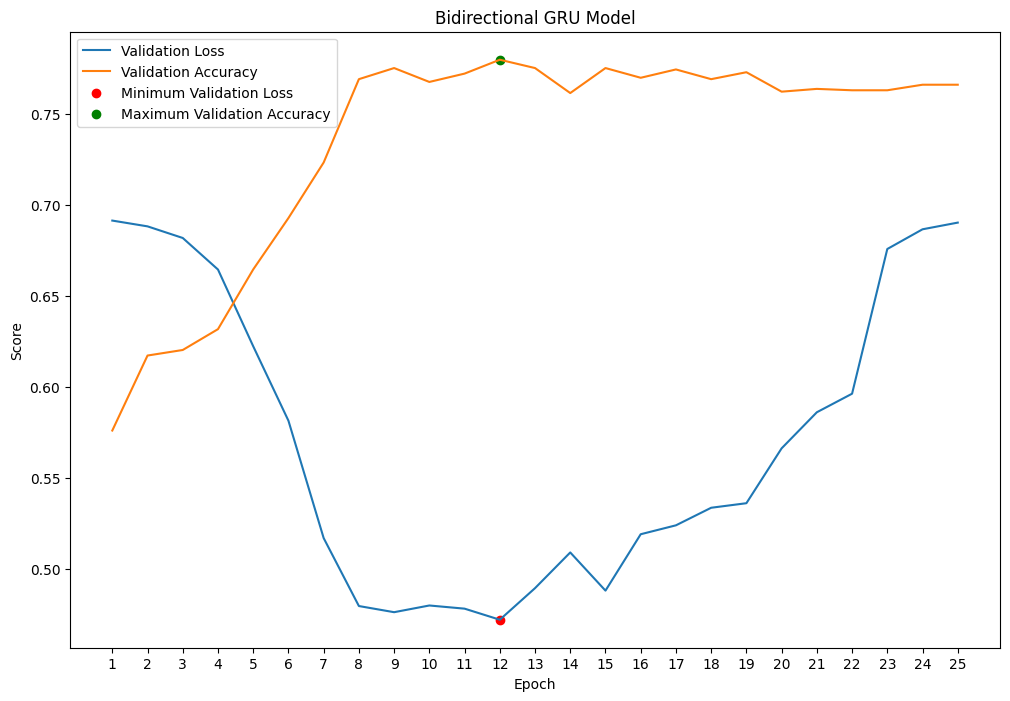

In [16]:
# Create model
model = tf.keras.models.Sequential()
model.add(Embedding(max_words, embedding_vecor_length, input_length = max_length))
model.add(Bidirectional(GRU(64, activation = 'relu', dropout = 0.1, recurrent_dropout = 0.1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

# Show Model Summary
print(model.summary())

# Fit Model and Validate
epochs = 25
history = model.fit(x_train, 
                    y_train, 
                    validation_data = (x_valid, y_valid), 
                    epochs = epochs, 
                    batch_size = 64,
                    verbose = 0)

# Print Summary
min_valloss_x = np.argmin(history.history['val_loss']) + 1
min_valloss_y = np.min(history.history['val_loss'])
print(f'Best Validation Loss: {min_valloss_y:.4f} at Epoch: {min_valloss_x}')
max_valacc_x = np.argmax(history.history['val_accuracy']) + 1
max_valacc_y = np.max(history.history['val_accuracy'])
print(f'Best Validation Accuracy: {max_valacc_y:.4f} at Epoch: {max_valacc_x}')

# Plot Results
epochs_list = [*range(1, epochs + 1, 1)]
plt.figure(figsize = (12, 8))
plt.title('Bidirectional GRU Model')
plt.plot(epochs_list, history.history['val_loss'], label = "Validation Loss")
plt.plot(epochs_list, history.history['val_accuracy'], label = "Validation Accuracy")
plt.scatter(min_valloss_x, min_valloss_y, c = 'r', label = 'Minimum Validation Loss')
plt.scatter(max_valacc_x, max_valacc_y, c = 'g', label = 'Maximum Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_list)
plt.ylabel('Score')
plt.legend()
plt.show()

### 3.6 2-layer Bidirectional GRU Model


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 32)            80000     
                                                                 
 bidirectional_2 (Bidirectio  (None, 32, 128)          37632     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              74496     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 192,257
Trainable params: 192,257
Non-tr

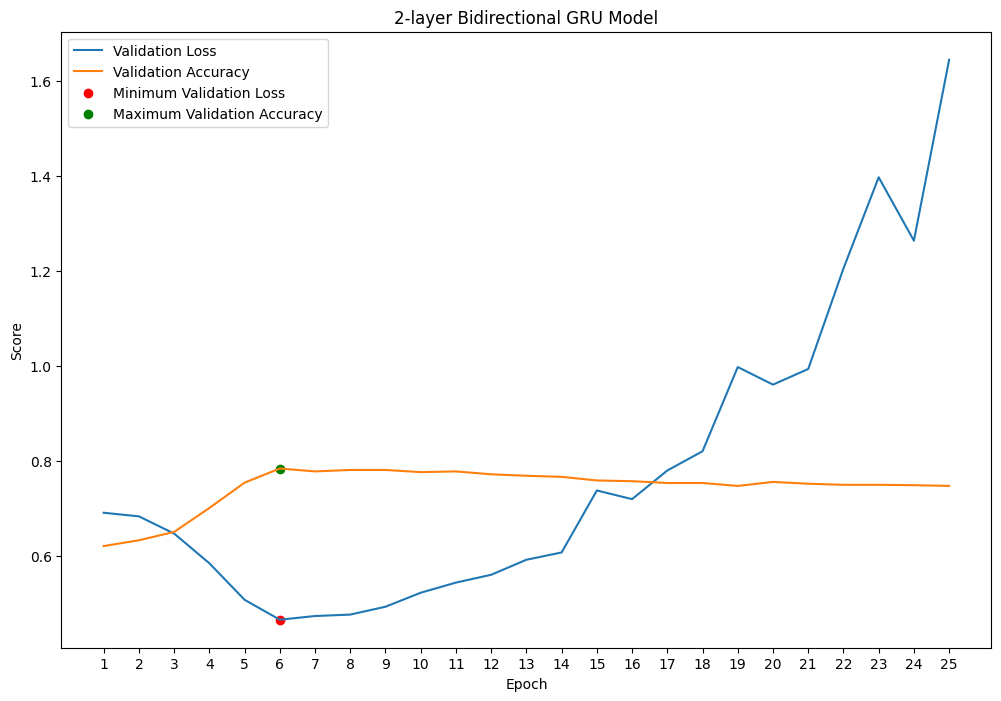

In [17]:
# Create model
model = tf.keras.models.Sequential()
model.add(Embedding(max_words, embedding_vecor_length, input_length = max_length))
model.add(Bidirectional(GRU(64, activation = 'relu', return_sequences = True, dropout = 0.1, recurrent_dropout = 0.1)))
model.add(Bidirectional(GRU(64, activation = 'relu', dropout = 0.1, recurrent_dropout = 0.1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', 
              optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

# Show Model Summary
print(model.summary())

# Fit Model and Validate
epochs = 25
history = model.fit(x_train, 
                    y_train, 
                    validation_data = (x_valid, y_valid), 
                    epochs = epochs, 
                    batch_size = 64,
                    callbacks = [model_checkpoint('model.h5')],
                    verbose = 0)

# Print Summary
min_valloss_x = np.argmin(history.history['val_loss']) + 1
min_valloss_y = np.min(history.history['val_loss'])
print(f'Best Validation Loss: {min_valloss_y:.4f} at Epoch: {min_valloss_x}')
max_valacc_x = np.argmax(history.history['val_accuracy']) + 1
max_valacc_y = np.max(history.history['val_accuracy'])
print(f'Best Validation Accuracy: {max_valacc_y:.4f} at Epoch: {max_valacc_x}')

# Plot Results
epochs_list = [*range(1, epochs + 1, 1)]
plt.figure(figsize = (12, 8))
plt.title('2-layer Bidirectional GRU Model')
plt.plot(epochs_list, history.history['val_loss'], label = "Validation Loss")
plt.plot(epochs_list, history.history['val_accuracy'], label = "Validation Accuracy")
plt.scatter(min_valloss_x, min_valloss_y, c = 'r', label = 'Minimum Validation Loss')
plt.scatter(max_valacc_x, max_valacc_y, c = 'g', label = 'Maximum Validation Accuracy')
plt.xlabel('Epoch')
plt.xticks(epochs_list)
plt.ylabel('Score')
plt.legend()
plt.show()

### 3.7 Generate Competition Submission File

The last run model will be used to create our submission file for Kaggle. The saved model checkpoint will be reloaded again.

The text for the test set will be tokenized and padded to the required length. After creating the predictions the final submission.csv is created.

In [18]:
# Prepare Submission text
test_X = tokenizer.texts_to_sequences(test_df.text.values)

# Truncate / Pad text for fixed length for LSTM / GRU
test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X, maxlen = max_length)

# Reload Best Model Weights
model.load_weights('model.h5')

# Test Predictions
preds = model.predict(test_X, verbose = 1)

# Finalize and Save Submission
submission_df.target = np.where(preds>0.5,1,0)
submission_df.to_csv('submission.csv', index = False)

# Summary
submission_df.head()

102/102 [==============================] - 6s 53ms/step


,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


If we submit our generated csv submission file through the Kaggle competition website we see that we have a nice score of 0.754.

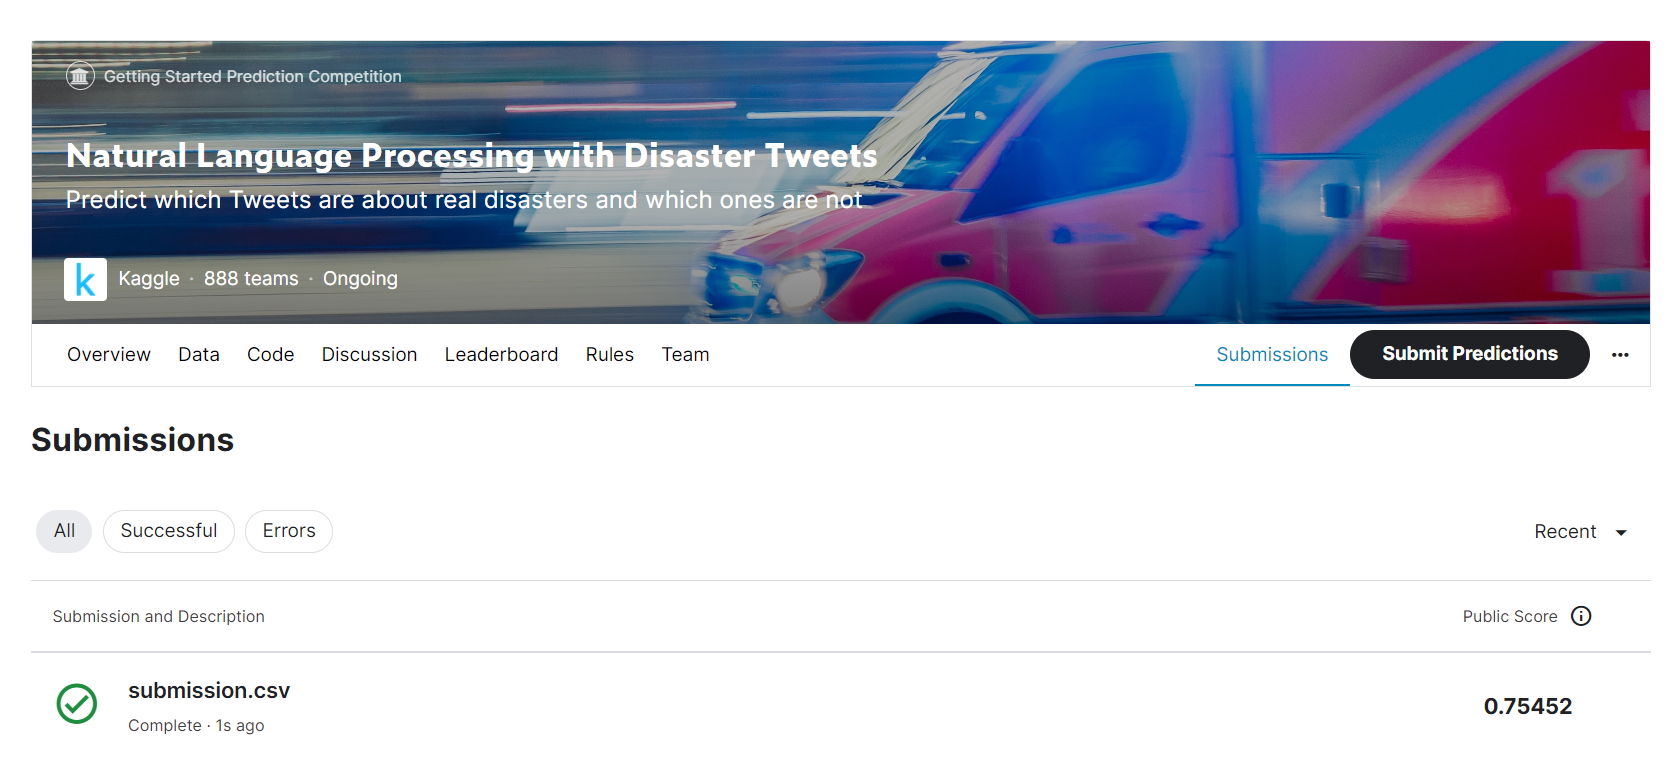

## 4. Hyperparameter tuning

With hyperparameter tuning we have the ability to optimize the hyperparameters for the specific model and dataset. This could lead to a higher performance on the validation dataset.

While there are many hyperparameters that can be tuned I have chosen to perform some tuning with the maximum amount of words that can be specified for the tokenizer. 

With various models already tested we've seen that the highest performance achieved by each of the models is roughly 77 to 78% accuracy. Therefore I will use the model as setup for the Basic LSTM Model to perform this test. Using the basic model setup saves a bit on training time required.

The procedure is simple. We create a list containing a few specific values that we would like to hyperparameter tune. We train a model and than we analyse the performance achieved with that specific value on the validation dataset.

We will look at the results of the hyperparameter tuning in the Results and Analysis section.

### 4.1 Maximum words to tokenize

The maximum words is used to specify the amount of top N occuring words that the tokenizer will take into account.
It basically determines how much different words will be tokenized. To low a number of maximum words and we will very likely loose information...if it is set to high however the model will likely at a certain moment suffer from the curse of dimensionality.

We will try 10 different values for the maximum words all in the range from 1000 to 10000.

In [19]:
# Placeholders
history_valloss_maxwords_list = []
history_valacc_maxwords_list = []

# Loop through list with max words
for max_words in [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]:
    # Clear Session
    tf.keras.backend.clear_session()
    
    # Prepare input features X and labels y.
    max_length = 32
    embedding_vecor_length = 32
    _, X, y = keras_vectorize_text(train_df, max_words = max_words, max_length = max_length)

    # Create Training and Validation sets
    x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.20, stratify = y, shuffle = True, random_state = 42)

    # Create model
    model = tf.keras.models.Sequential()
    model.add(Embedding(max_words, embedding_vecor_length, input_length = max_length))
    model.add(GRU(64, activation = 'relu', dropout = 0.1, recurrent_dropout = 0.1))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss = 'binary_crossentropy', 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), 
                  metrics = ['accuracy'])

    # Fit Model and Validate
    epochs = 25
    history = model.fit(x_train, 
                        y_train, 
                        validation_data = (x_valid, y_valid), 
                        epochs = epochs, 
                        batch_size = 64,
                        verbose = 0)

    # Add Metrics to list
    history_valloss_maxwords_list.append(history.history['val_loss'])
    history_valacc_maxwords_list.append(history.history['val_accuracy'])

## 5. Results and Analysis 

Below are presented the results and analysis for the training and validation of the model architectures and the hyperparameter tuning experimen

### 5.1 Results for Model Architectures

The GradientBoostingClassifier scored around 74% accuracy on the validation set. The different LSTM and GRU models all score around 77 to 78% accuracy on the validation set.
These models clearly show a performance improvement compared to a classic classifier.

An important thing to notice is that if we compare the Basic LSTM and GRU model compared to the 2-layer Bidirectional GRU model the performance increase from a complex architecture is very minor and likely not worth the required additional compute time.

The 2 layer Bidirectional GRU model does however achieve its best validation loss and accuracy already at epoch 6 while all the other single layer LSTM and GRU models achieve there best validation loss and accuracy after about 8 to 14 epochs. So the additional compute time is likely offset by the fewer epochs required.

### 5.2 Hyperparameter tuning - Maximum Words Results

If we look at the validation loss and accuracy for the different values of the maximum words we can see that the lowest value of maximum words - 1000 - gives both the highest accuracy and the lowest validation loss.

On average the higher the maximum words value gets the worse the validation loss and accuracy performance are.

The most likely explanation that the lowest maximum word count performance is the best is the fact that the data set is small and contains relatively little different words.

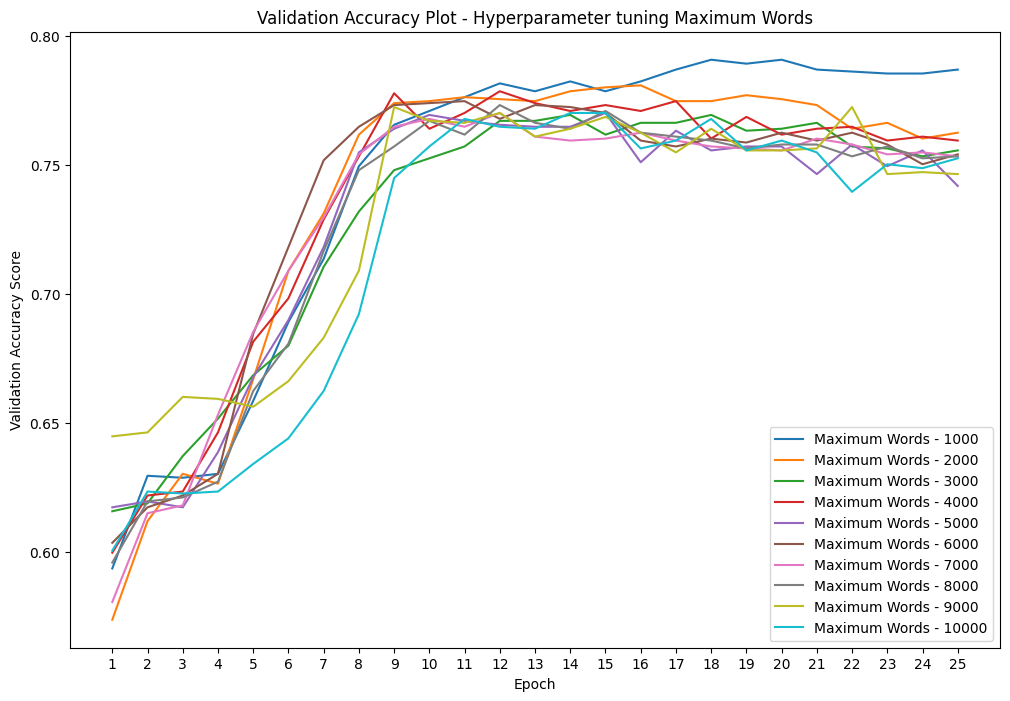

In [20]:
# Plot results for Maximum Words Hyperparameter tuning
epochs_list = list(range(1, len(history_valacc_maxwords_list[0])+1))
labels_list = []
for max_words in [*range(1000, 11000, 1000)]:
    labels_list.append(f'Maximum Words - {max_words}')
plt.figure(figsize=(12, 8)) 
plt.xlabel("Epoch")
plt.xticks(epochs_list)
plt.ylabel("Validation Accuracy Score")
plt.title("Validation Accuracy Plot - Hyperparameter tuning Maximum Words")

for i in range(len(history_valacc_maxwords_list)):
    plt.plot(epochs_list, history_valacc_maxwords_list[i], label = f'{labels_list[i]}')
plt.legend(loc = 'lower right')
plt.show()

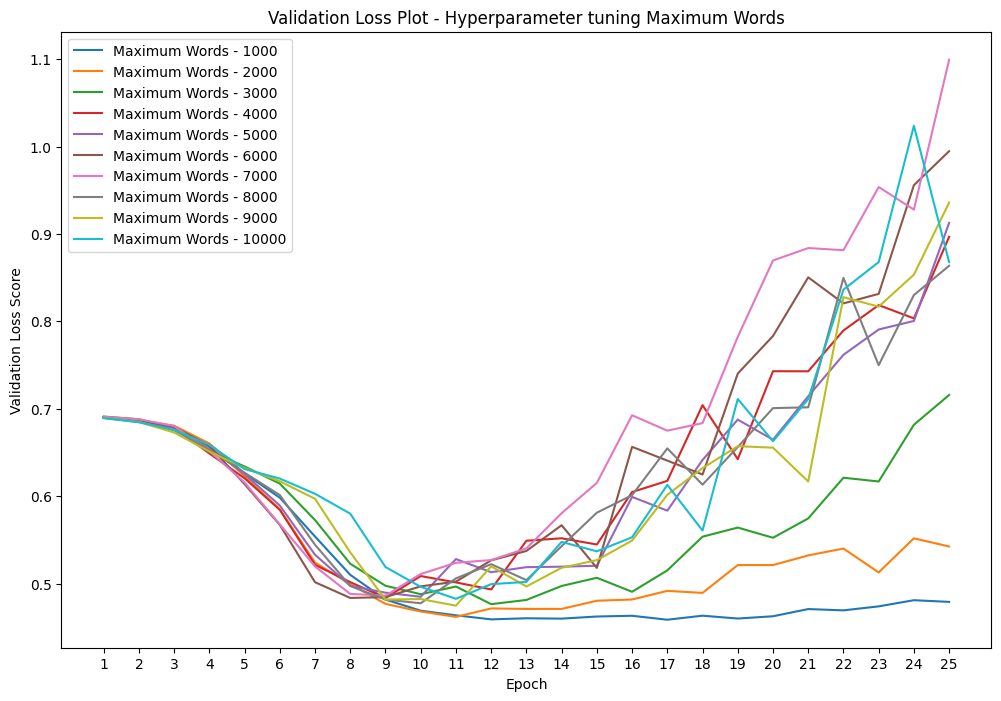

In [21]:
# Plot results for Maximum Words Hyperparameter tuning
epochs_list = list(range(1, len(history_valloss_maxwords_list[0])+1))
labels_list = []
for max_words in [*range(1000, 11000, 1000)]:
    labels_list.append(f'Maximum Words - {max_words}')
plt.figure(figsize=(12, 8)) 
plt.xlabel("Epoch")
plt.xticks(epochs_list)
plt.ylabel("Validation Loss Score")
plt.title("Validation Loss Plot - Hyperparameter tuning Maximum Words")

for i in range(len(history_valloss_maxwords_list)):
    plt.plot(epochs_list, history_valloss_maxwords_list[i], label = f'{labels_list[i]}')
plt.legend(loc = 'upper left')
plt.show()

## 6. Conclusion

We've looked at different models, trained and validated them. Also we performed a hyperparameter tuning experiments which gave us insight into the performance achieved when varying the Maximum Words for the tokenizer.

The most interresting point to notice is that even with a very small dataset the LSTM and GRU models can achieve a very decent performance. Normally with deep learning a lot more data is required but these models turn out to be not really data hungry.

Further options that could be explored to improve the performance even more in the future would be the following:
1. Use Cross Validation for training and create ensembles of the models. Average the predicted probabilities.
2. Further hyperparameter tuning. There are a lot more parameters that can be explored.
3. Learning Rate scheduling.
4. Trying further custom LSTM and GRU model architectures.